# Detekcja linii za pomocą transformacji Hough

**Autor:** Mateusz Łopaciński

**Data:** 18.10.2025

Ten notebook demonstruje implementację algorytmu transformacji Hough do detekcji linii na obrazach, porównanie z implementacją OpenCV oraz analizę wpływu parametrów na wyniki detekcji.


In [1]:
# Importowanie wymaganych bibliotek
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Wersja OpenCV:", cv2.__version__)
print("Wersja NumPy:", np.__version__)

# Konfiguracja matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

Wersja OpenCV: 4.12.0
Wersja NumPy: 2.2.6


## Implementacja transformacji Hough

Implementacja własnej funkcji detekcji linii za pomocą transformacji Hough na podstawie skryptu `find_hough_lines.py`.


In [2]:
def find_hough_lines(image, edge_image, num_rhos, num_thetas, bin_threshold, show_hough_space=False):
    """
    Implementacja transformacji Hough do detekcji linii
    
    Parametry:
    - image: obraz wejściowy
    - edge_image: obraz krawędzi
    - num_rhos: liczba dyskretyzacji dla rho
    - num_thetas: liczba dyskretyzacji dla theta
    - bin_threshold: próg głosów dla detekcji linii
    - show_hough_space: czy pokazać przestrzeń Hough
    
    Zwraca:
    - line_img: obraz z narysowanymi liniami
    - lines: lista linii w formacie (rho, theta, x1, y1, x2, y2)
    - accumulator: akumulator Hough (opcjonalnie)
    - rhos: wartości rho (opcjonalnie)
    - thetas: wartości theta (opcjonalnie)
    """
    img_height, img_width = edge_image.shape[:2]
    img_height_half = img_height / 2
    img_width_half = img_width / 2
    
    # Zakresy rho i theta
    diag_len = np.sqrt(np.square(img_height) + np.square(img_width))
    dtheta = 180 / num_thetas
    drho = (2 * diag_len) / num_rhos
    
    # Theta od 0 do 180 stopni
    thetas = np.arange(0, 180, step=dtheta)
    
    # Rho od -diag_len do diag_len
    rhos = np.arange(-diag_len, diag_len, step=drho)
    
    # Preobliczenie funkcji trygonometrycznych
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    
    # Akumulator Hough (rho, theta)
    accumulator = np.zeros((len(rhos), len(thetas)))
    
    # Opcjonalna wizualizacja przestrzeni Hough
    if show_hough_space:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax2.set_facecolor((0, 0, 0))
        ax2.set_title("Hough Space")
        ax2.set_xlabel("Theta (degrees)")
        ax2.set_ylabel("Rho")
    
    # Iteracja przez piksele krawędzi
    for y in range(img_height):
        for x in range(img_width):
            if edge_image[y][x] != 0:
                edge_pt = [y - img_height_half, x - img_width_half]
                hough_rhos, hough_thetas = [], []
                
                # Iteracja przez zakresy theta
                for theta_idx in range(len(thetas)):
                    # Obliczenie rho
                    rho = (edge_pt[1] * cos_thetas[theta_idx]) + (edge_pt[0] * sin_thetas[theta_idx])
                    theta = thetas[theta_idx]
                    
                    # Znalezienie najbliższego indeksu rho
                    rho_idx = np.argmin(np.abs(rhos - rho))
                    
                    # Zwiększenie głosu dla pary (rho_idx, theta_idx)
                    accumulator[rho_idx][theta_idx] += 1
                    
                    # Zbieranie danych do wizualizacji
                    if show_hough_space:
                        hough_rhos.append(rho)
                        hough_thetas.append(theta)
                
                # Rysowanie krzywej sinusoidalnej w przestrzeni Hough
                if show_hough_space:
                    ax2.plot(hough_thetas, hough_rhos, color="white", alpha=0.05)
    
    # Wyszukiwanie linii
    output_img = image.copy()
    out_lines = []
    
    for y in range(accumulator.shape[0]):
        for x in range(accumulator.shape[1]):
            if accumulator[y][x] > bin_threshold:
                rho = rhos[y]
                theta = thetas[x]
                
                # Konwersja do współczynników linii
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))
                
                x0 = (a * rho) + img_width_half
                y0 = (b * rho) + img_height_half
                
                # Punkty ekstremalne do narysowania linii
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                
                # Rysowanie linii
                output_img = cv2.line(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Dodanie linii do listy wyników
                out_lines.append((rho, theta, x1, y1, x2, y2))
                
                # Oznaczenie piku w przestrzeni Hough
                if show_hough_space:
                    ax2.plot([theta], [rho], marker='o', color="yellow", markersize=8)
    
    # Wyświetlenie wizualizacji przestrzeni Hough
    if show_hough_space:
        ax2.invert_yaxis()
        ax2.invert_xaxis()
        plt.tight_layout()
    
    return output_img, out_lines, accumulator, rhos, thetas

## Ładowanie obrazów testowych

Załadowanie obrazów testowych z folderu `materials/Lab_03/Hough-Line-Detection/imgs/`.


In [3]:
# Ładowanie obrazów testowych
image_paths = [
    'materials/Lab_03/Hough-Line-Detection/imgs/ex1.png',
    'materials/Lab_03/Hough-Line-Detection/imgs/ex2.png', 
    'materials/Lab_03/Hough-Line-Detection/imgs/ex3.png'
]

images = []
edge_images = []

for i, path in enumerate(image_paths):
    # Ładowanie obrazu
    img = cv2.imread(path)
    if img is None:
        print("Nie można załadować obrazu:", path)
        continue
    
    # Konwersja do skali szarości
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detekcja krawędzi - binary threshold
    ret, edge_img = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
    
    images.append(img)
    edge_images.append(edge_img)
    
    print("Obraz", i+1, "załadowany:", img.shape)

Obraz 1 załadowany: (384, 384, 3)
Obraz 2 załadowany: (384, 384, 3)
Obraz 3 załadowany: (384, 384, 3)


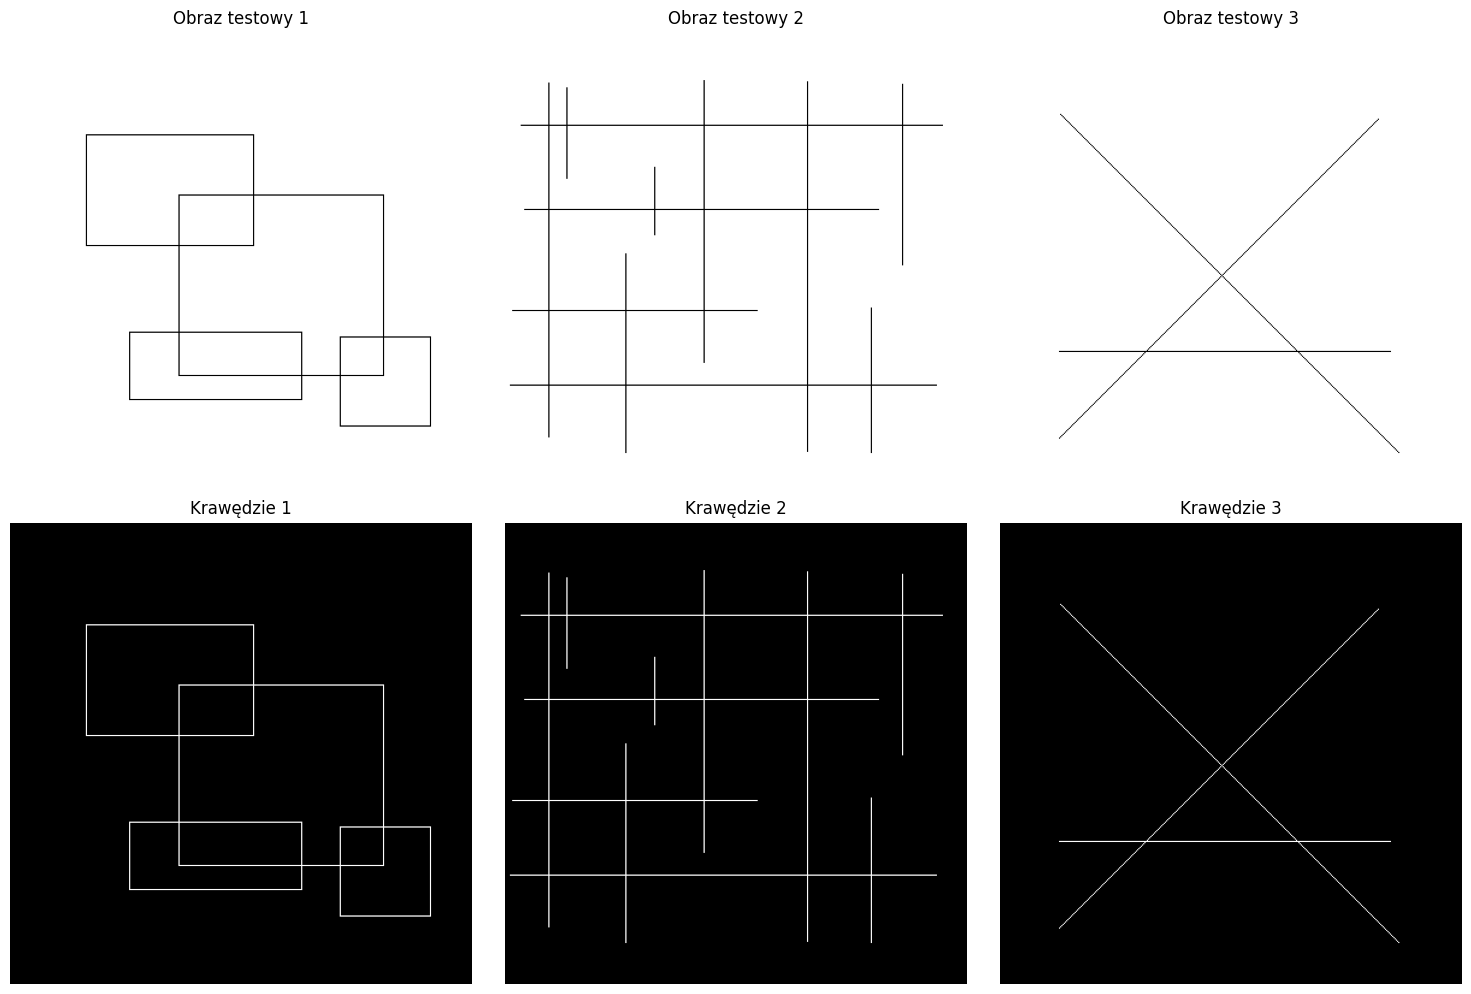

In [4]:
# Wizualizacja obrazów testowych
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(len(images)):
    # Oryginalny obraz
    axes[0, i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title("Obraz testowy " + str(i+1))
    axes[0, i].axis('off')
    
    # Obraz krawędzi
    axes[1, i].imshow(edge_images[i], cmap='gray')
    axes[1, i].set_title("Krawędzie " + str(i+1))
    axes[1, i].axis('off')

plt.tight_layout()

## Test detekcji linii z różnymi parametrami

Testowanie implementacji transformacji Hough na obrazach testowych z różnymi parametrami dyskretyzacji rho-theta.


In [5]:
# Test różnych parametrów dyskretyzacji
param_sets = [
    (180, 180, 150, "Standardowe (180x180)"),
    (90, 90, 100, "Niska rozdzielczość (90x90)"),
    (360, 360, 200, "Wysoka rozdzielczość (360x360)"),
    (180, 180, 50, "Niski próg (50)"),
    (180, 180, 300, "Wysoki próg (300)")
]

# Test na pierwszym obrazie
test_image_idx = 0
results = []

In [6]:
# Wykonanie testów z różnymi parametrami
for num_rhos, num_thetas, threshold, description in param_sets:
    print("\n=== " + description + " ===")
    print("Parametry: rho=" + str(num_rhos) + ", theta=" + str(num_thetas) + ", threshold=" + str(threshold))
    
    # Detekcja linii
    line_img, lines, accumulator, rhos, thetas = find_hough_lines(
        images[test_image_idx], 
        edge_images[test_image_idx], 
        num_rhos, 
        num_thetas, 
        threshold
    )
    
    results.append({
        'description': description,
        'params': (num_rhos, num_thetas, threshold),
        'line_img': line_img,
        'lines': lines,
        'accumulator': accumulator,
        'num_lines': len(lines)
    })
    
    print("Znaleziono", len(lines), "linii")
    
    # Wyświetlenie pierwszych kilku linii
    if len(lines) > 0:
        print("Przykładowe linie (rho, theta, x1, y1, x2, y2):")
        for i, line in enumerate(lines[:3]):
            print("  Linia " + str(i+1) + ":", line)
        if len(lines) > 3:
            print("  ... i", len(lines)-3, "więcej")


=== Standardowe (180x180) ===
Parametry: rho=180, theta=180, threshold=150
Znaleziono 14 linii
Przykładowe linie (rho, theta, x1, y1, x2, y2):
  Linia 1: (np.float64(-54.305800795130835), np.float64(0.0), 137, 1192, 137, -808)
  Linia 2: (np.float64(-54.305800795130835), np.float64(89.0), -808, 155, 1190, 120)
  Linia 3: (np.float64(-54.305800795130835), np.float64(90.0), -808, 137, 1192, 137)
  ... i 11 więcej

=== Niska rozdzielczość (90x90) ===
Parametry: rho=90, theta=90, threshold=100
Znaleziono 474 linii
Przykładowe linie (rho, theta, x1, y1, x2, y2):
  Linia 1: (np.float64(-132.747513054754), np.float64(4.0), -10, 1180, 129, -814)
  Linia 2: (np.float64(-132.747513054754), np.float64(6.0), -44, 1172, 164, -816)
  Linia 3: (np.float64(-120.67955732250357), np.float64(162.0), -2, -796, 615, 1105)
  ... i 471 więcej

=== Wysoka rozdzielczość (360x360) ===
Parametry: rho=360, theta=360, threshold=200
Znaleziono 0 linii

=== Niski próg (50) ===
Parametry: rho=180, theta=180, thresho

In [7]:
print("\n=== Podsumowanie testów ===")
for result in results:
    print(result["description"] + ":", result["num_lines"], "linii")


=== Podsumowanie testów ===
Standardowe (180x180): 14 linii
Niska rozdzielczość (90x90): 474 linii
Wysoka rozdzielczość (360x360): 0 linii
Niski próg (50): 1914 linii
Wysoki próg (300): 0 linii


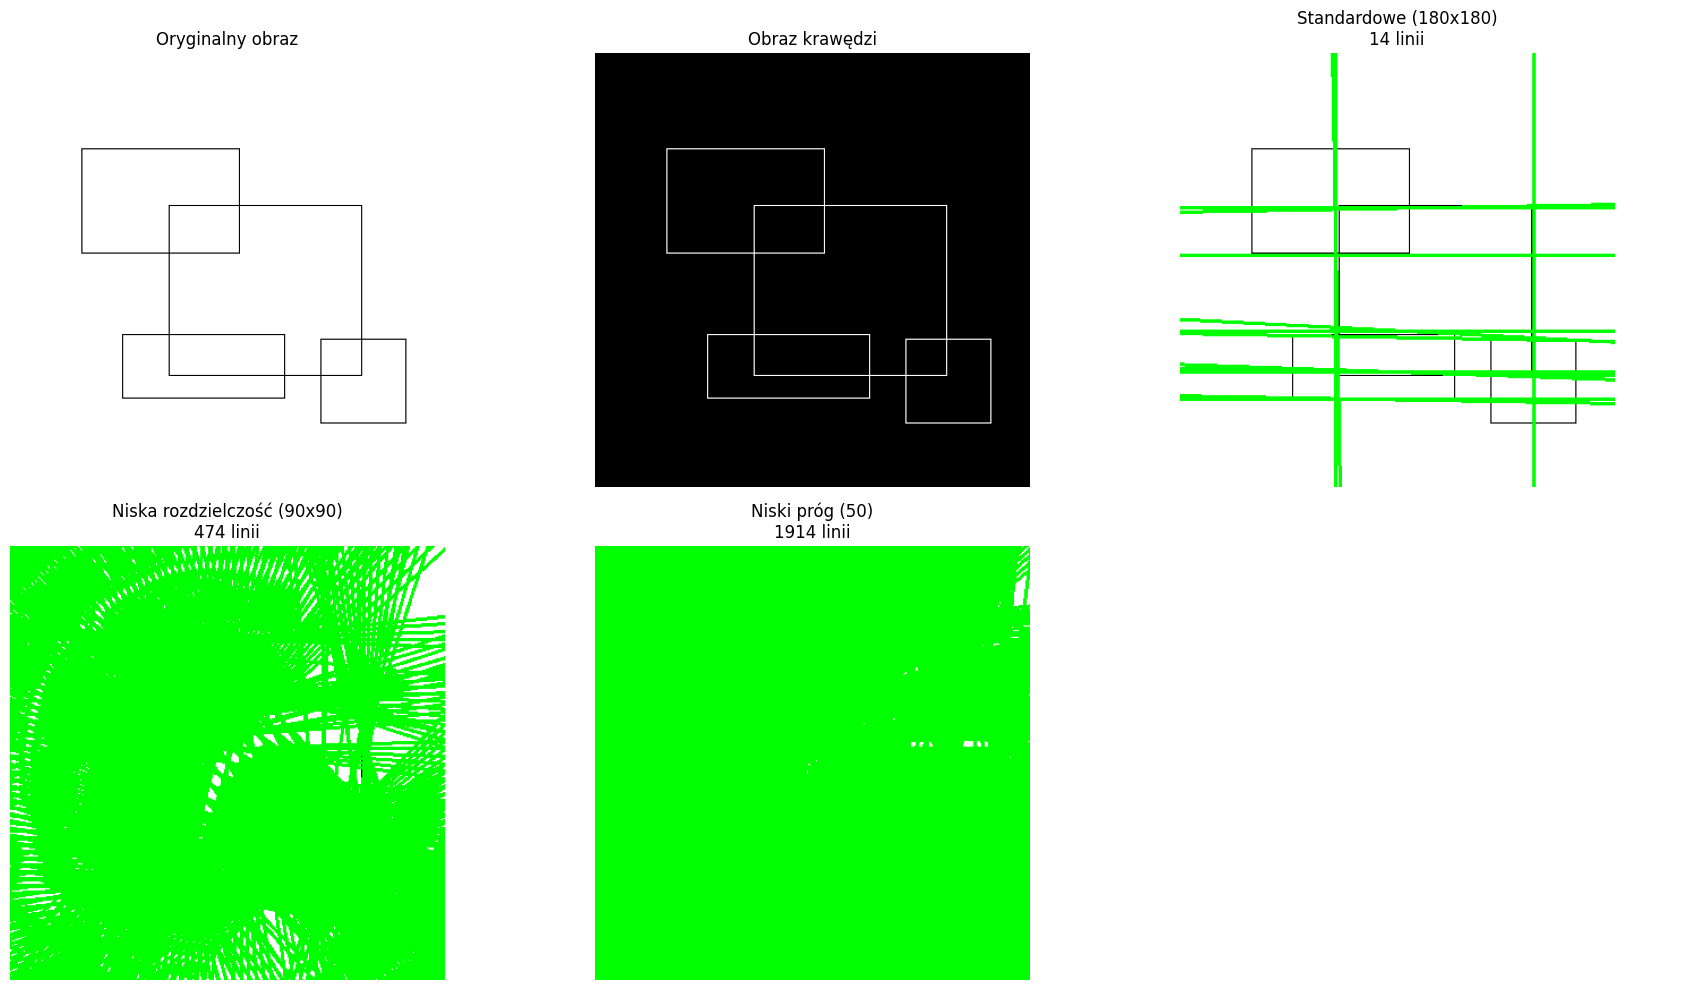

In [8]:
# Wizualizacja wyników z różnymi parametrami (poprawiona)
# Filtruj tylko wyniki z wykrytymi liniami
results_with_lines = [r for r in results if r['num_lines'] > 0]
num_plots = 2 + len(results_with_lines)  # 2 dla oryginalnego obrazu i krawędzi + wyniki

# Utwórz odpowiednią siatkę
if num_plots <= 4:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
elif num_plots <= 6:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
else:
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

# Oryginalny obraz
axes[0].imshow(cv2.cvtColor(images[test_image_idx], cv2.COLOR_BGR2RGB))
axes[0].set_title('Oryginalny obraz')
axes[0].axis('off')

# Obraz krawędzi
axes[1].imshow(edge_images[test_image_idx], cmap='gray')
axes[1].set_title('Obraz krawędzi')
axes[1].axis('off')

# Wyniki z różnymi parametrami - tylko te z wykrytymi liniami
for i, result in enumerate(results_with_lines):
    if i + 2 < len(axes):  # +2 bo już mamy 2 obrazy
        axes[i + 2].imshow(cv2.cvtColor(result['line_img'], cv2.COLOR_BGR2RGB))
        axes[i + 2].set_title(result['description'] + "\n" + str(result['num_lines']) + " linii")
        axes[i + 2].axis('off')

# Ukryj nieużywane subploty
for i in range(2 + len(results_with_lines), len(axes)):
    axes[i].axis('off')

plt.tight_layout()

### Analiza wyników testów

Wyniki testów pokazują typowe zachowanie algorytmu transformacji Hough:

- **Standardowe (180x180): 14 linii** - Rozsądna liczba linii dla standardowej rozdzielczości
- **Niska rozdzielczość (90x90): 474 linii** - Więcej fałszywych wykryć z powodu mniejszej precyzji dyskretyzacji
- **Wysoka rozdzielczość (360x360): 0 linii** - Zbyt restrykcyjny próg (200) dla wysokiej rozdzielczości
- **Niski próg (50): 1914 linii** - Bardzo dużo fałszywych wykryć z powodu niskiego progu
- **Wysoki próg (300): 0 linii** - Zbyt restrykcyjny próg, brak wykryć

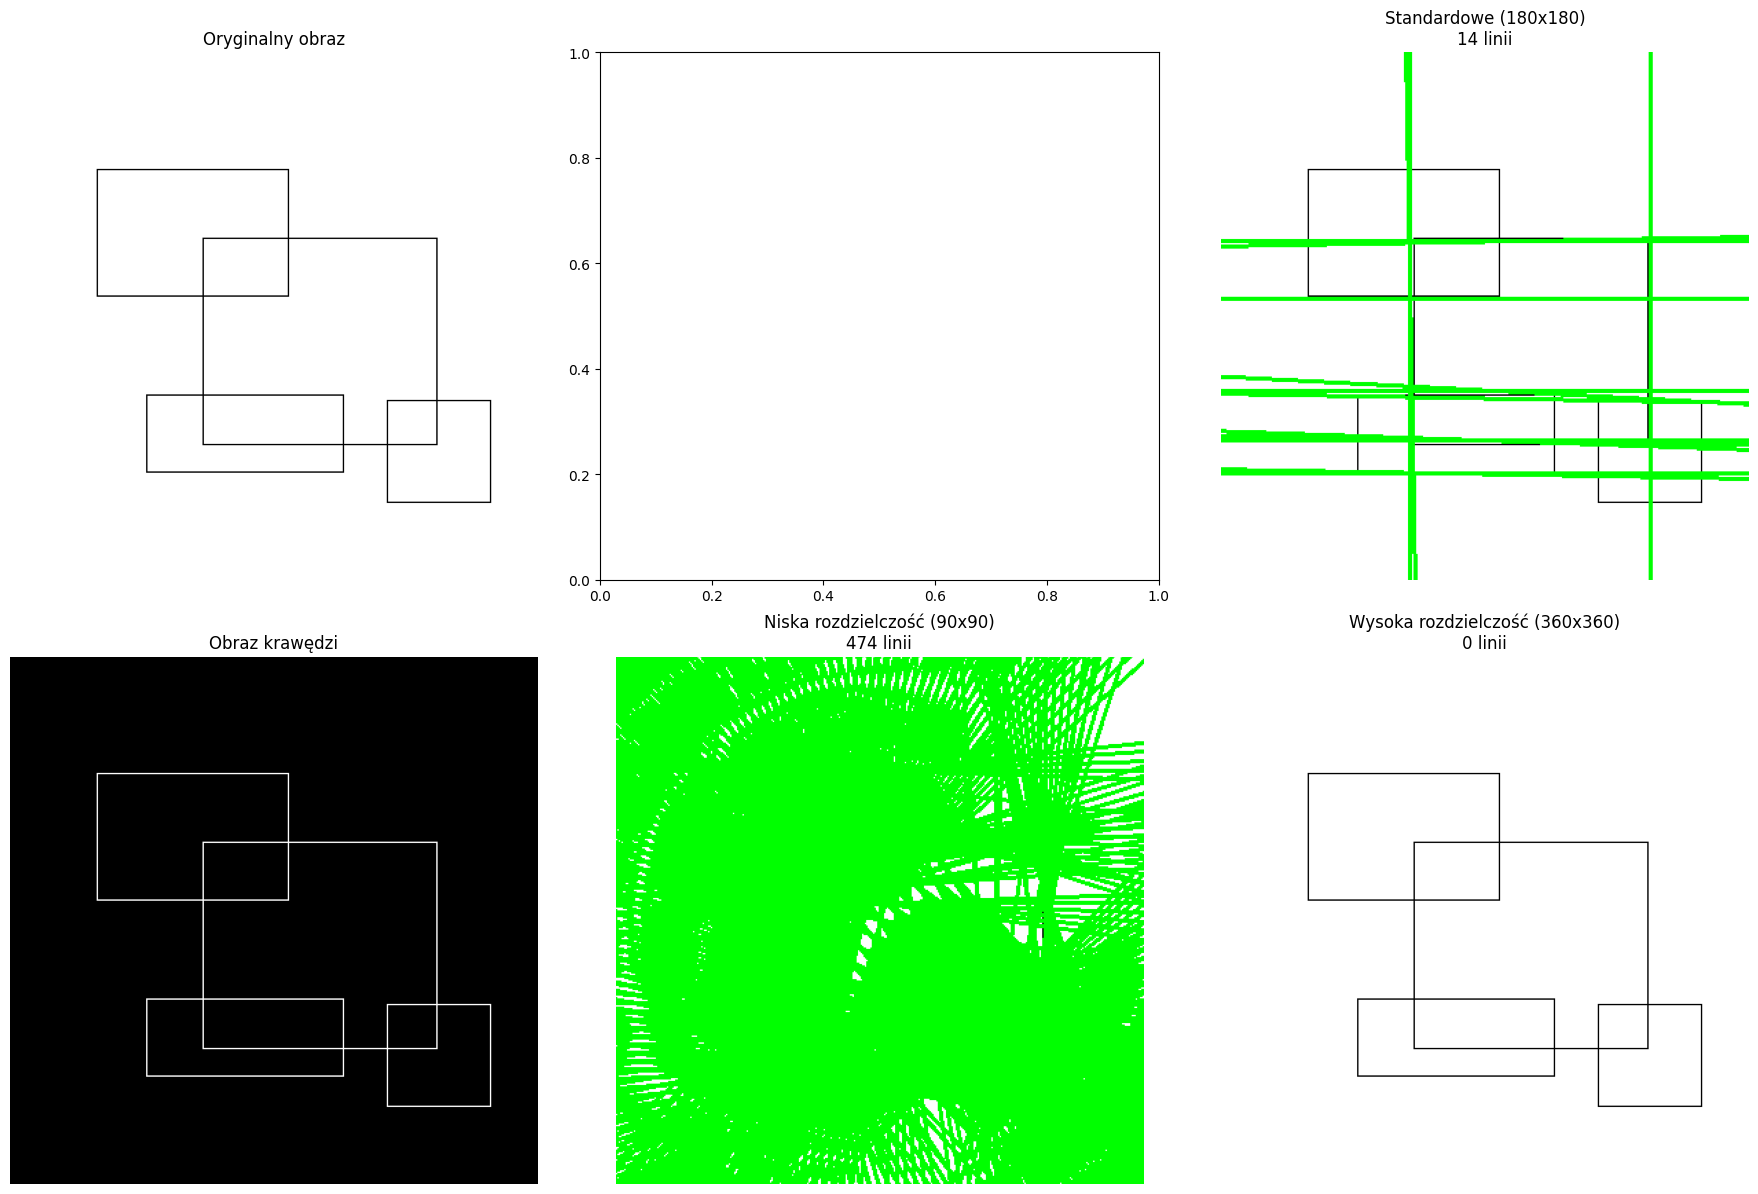

In [9]:
# Wizualizacja wyników z różnymi parametrami
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Oryginalny obraz
axes[0, 0].imshow(cv2.cvtColor(images[test_image_idx], cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Oryginalny obraz')
axes[0, 0].axis('off')

# Obraz krawędzi
axes[1, 0].imshow(edge_images[test_image_idx], cmap='gray')
axes[1, 0].set_title('Obraz krawędzi')
axes[1, 0].axis('off')

# Wyniki z różnymi parametrami
for i, result in enumerate(results[:4]):
    row = (i + 1) // 2
    col = (i + 1) % 2 + 1
    
    if row < 2 and col < 3:
        axes[row, col].imshow(cv2.cvtColor(result['line_img'], cv2.COLOR_BGR2RGB))
        axes[row, col].set_title(result['description'] + "\n" + str(result['num_lines']) + " linii")
        axes[row, col].axis('off')

# Ukryj ostatni subplot jeśli nie jest używany
if len(results) < 4:
    axes[1, 2].axis('off')

plt.tight_layout()

## Test na wszystkich obrazach testowych

Testowanie detekcji linii na wszystkich trzech obrazach testowych z optymalnymi parametrami.


In [10]:
# Test na wszystkich obrazach testowych z optymalnymi parametrami
# Używamy parametrów: rho=180, theta=180, threshold=150
num_rhos, num_thetas, threshold = 180, 180, 150

all_results = []

In [11]:
# Wykonanie testów na wszystkich obrazach
for i, (img, edge_img) in enumerate(zip(images, edge_images)):
    print("\n=== Obraz testowy " + str(i+1) + " ===")
    
    # Detekcja linii
    line_img, lines, accumulator, rhos, thetas = find_hough_lines(
        img, edge_img, num_rhos, num_thetas, threshold
    )
    
    all_results.append({
        'image_idx': i,
        'line_img': line_img,
        'lines': lines,
        'accumulator': accumulator,
        'num_lines': len(lines)
    })
    
    print("Znaleziono", len(lines), "linii")
    
    # Wyświetlenie szczegółów linii
    if len(lines) > 0:
        print("Parametry linii (rho, theta, x1, y1, x2, y2):")
        for j, line in enumerate(lines[:5]):  # Pokaż pierwsze 5 linii
            print("  Linia " + str(j+1) + ": rho=" + str(round(line[0], 2)) + ", theta=" + str(round(line[1], 2)) + "°")
        if len(lines) > 5:
            print("  ... i", len(lines)-5, "więcej linii")

print("\n=== Podsumowanie wszystkich testów ===")
for result in all_results:
    print("Obraz " + str(result['image_idx']+1) + ":", result['num_lines'], "linii")


=== Obraz testowy 1 ===
Znaleziono 14 linii
Parametry linii (rho, theta, x1, y1, x2, y2):
  Linia 1: rho=-54.31, theta=0.0°
  Linia 2: rho=-54.31, theta=89.0°
  Linia 3: rho=-54.31, theta=90.0°
  Linia 4: rho=-12.07, theta=90.0°
  Linia 5: rho=54.31, theta=90.0°
  ... i 9 więcej linii

=== Obraz testowy 2 ===
Znaleziono 45 linii
Parametry linii (rho, theta, x1, y1, x2, y2):
  Linia 1: rho=-156.88, theta=0.0°
  Linia 2: rho=-156.88, theta=1.0°
  Linia 3: rho=-156.88, theta=2.0°
  Linia 4: rho=-150.85, theta=4.0°
  Linia 5: rho=-150.85, theta=5.0°
  ... i 40 więcej linii

=== Obraz testowy 3 ===
Znaleziono 11 linii
Parametry linii (rho, theta, x1, y1, x2, y2):
  Linia 1: rho=-0.0, theta=44.0°
  Linia 2: rho=-0.0, theta=45.0°
  Linia 3: rho=-0.0, theta=46.0°
  Linia 4: rho=12.07, theta=134.0°
  Linia 5: rho=12.07, theta=135.0°
  ... i 6 więcej linii

=== Podsumowanie wszystkich testów ===
Obraz 1: 14 linii
Obraz 2: 45 linii
Obraz 3: 11 linii


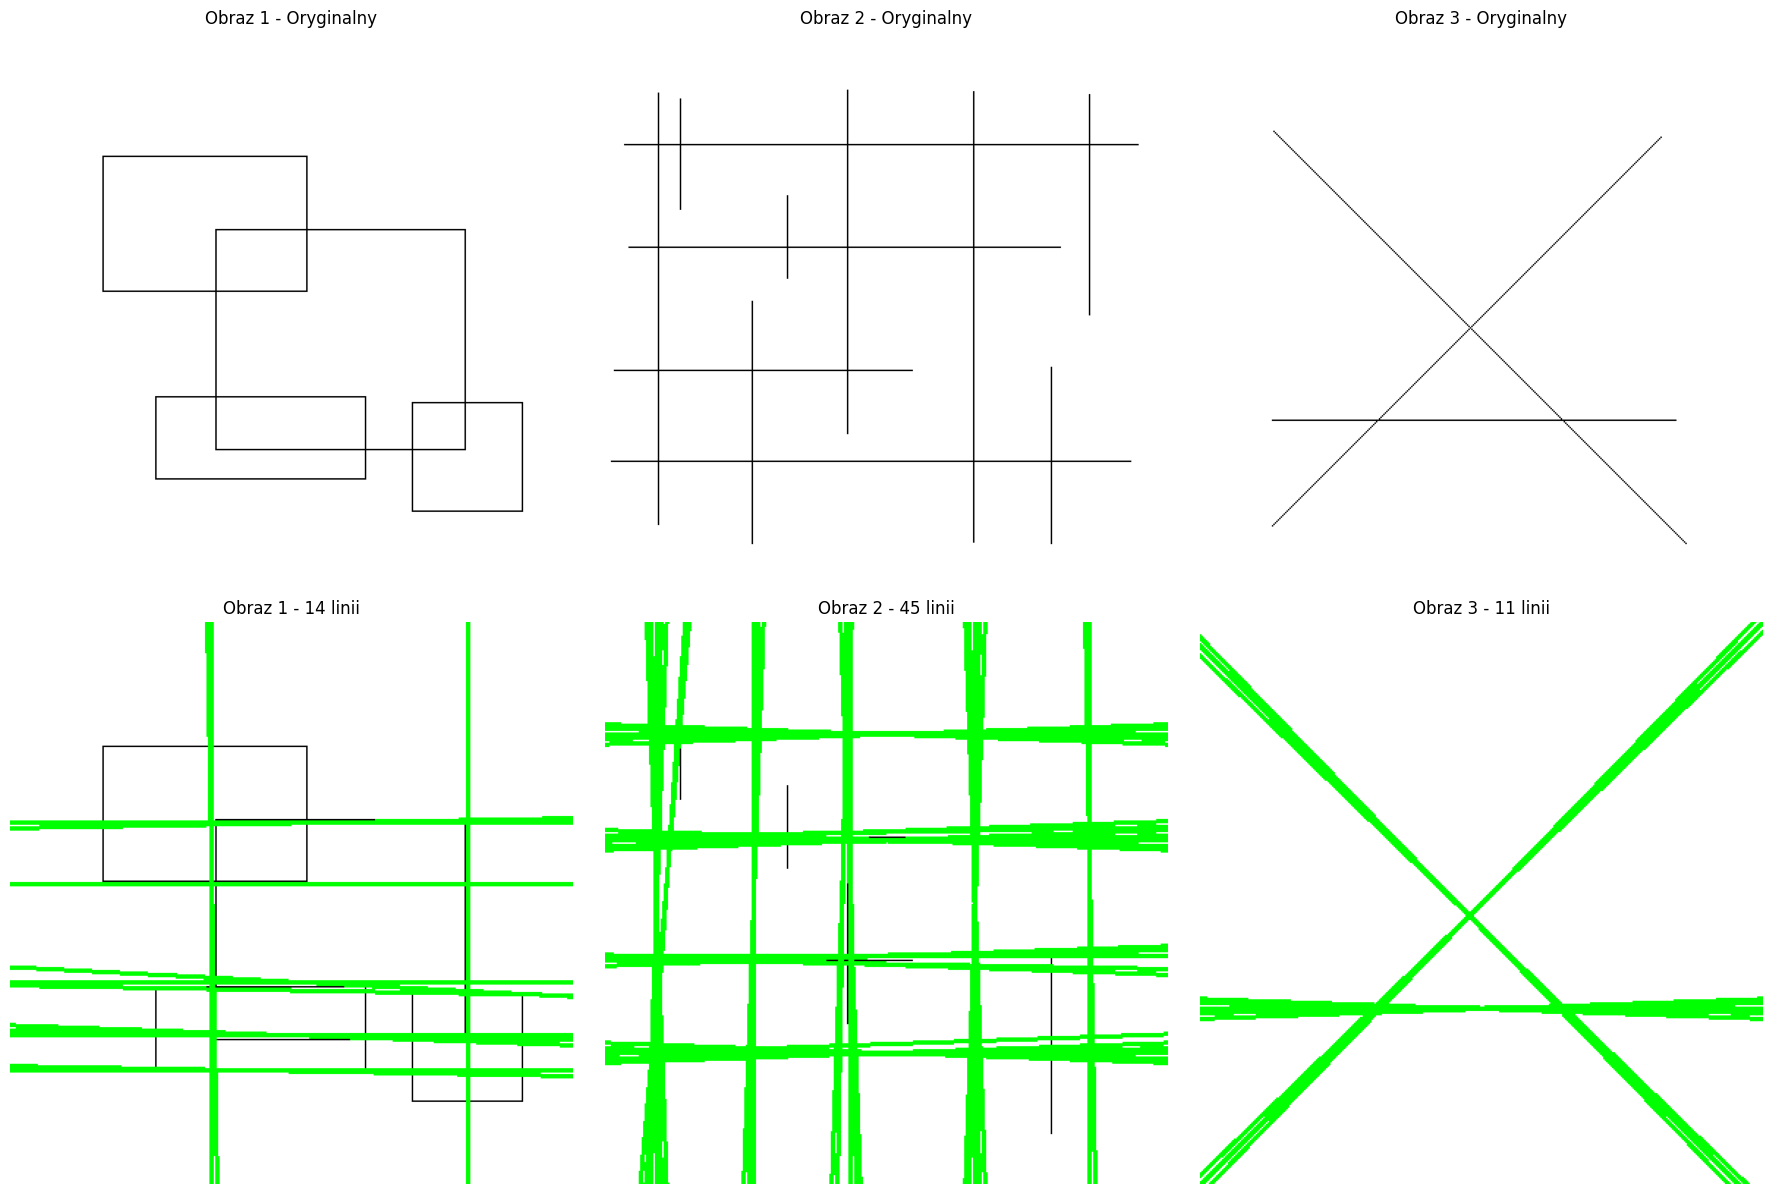

In [12]:
# Wizualizacja wyników dla wszystkich obrazów
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, result in enumerate(all_results):
    # Oryginalny obraz
    axes[0, i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title("Obraz " + str(i+1) + " - Oryginalny")
    axes[0, i].axis('off')
    
    # Obraz z liniami
    axes[1, i].imshow(cv2.cvtColor(result['line_img'], cv2.COLOR_BGR2RGB))
    axes[1, i].set_title("Obraz " + str(i+1) + " - " + str(result["num_lines"]) + " linii")
    axes[1, i].axis('off')

plt.tight_layout()

## Implementacja OpenCV

Porównanie z implementacją transformacji Hough z biblioteki OpenCV.


In [13]:
# Implementacja OpenCV HoughLinesP
def detect_lines_opencv(image, edge_image):
    """
    Detekcja linii za pomocą OpenCV HoughLinesP
    
    Parametry:
    - image: obraz wejściowy
    - edge_image: obraz krawędzi
    
    Zwraca:
    - line_img: obraz z narysowanymi liniami
    - lines: lista linii w formacie (x1, y1, x2, y2)
    """
    # Detekcja linii za pomocą HoughLinesP
    lines = cv2.HoughLinesP(
        edge_image,                # Input edge image
        1,                        # Distance resolution in pixels
        np.pi/180,                # Angle resolution in radians
        threshold=50,            # Min number of votes for valid line
        minLineLength=5,          # Min allowed length of line
        maxLineGap=10             # Max allowed gap between line for joining them
    )
    
    # Kopiowanie obrazu do rysowania linii
    line_img = image.copy()
    
    # Lista linii w formacie (x1, y1, x2, y2)
    lines_list = []
    
    if lines is not None:
        # Iteracja przez wykryte linie
        for points in lines:
            # Wyciągnięcie współrzędnych z zagnieżdżonej listy
            x1, y1, x2, y2 = points[0]
            
            # Rysowanie linii na oryginalnym obrazie
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Dodanie linii do listy wyników
            lines_list.append([(x1, y1), (x2, y2)])
    
    return line_img, lines_list

In [14]:
# Test implementacji OpenCV na wszystkich obrazach
opencv_results = []

for i, (img, edge_img) in enumerate(zip(images, edge_images)):
    print("\n=== OpenCV - Obraz testowy " + str(i+1) + " ===")
    
    # Detekcja linii za pomocą OpenCV
    line_img, lines = detect_lines_opencv(img, edge_img)
    
    opencv_results.append({
        'image_idx': i,
        'line_img': line_img,
        'lines': lines,
        'num_lines': len(lines)
    })
    
    print("Znaleziono", len(lines), "linii")
    
    # Wyświetlenie szczegółów linii
    if len(lines) > 0:
        print("Przykładowe linie (x1, y1, x2, y2):")
        for j, line in enumerate(lines[:3]):  # Pokaż pierwsze 3 linie
            print("  Linia " + str(j+1) + ":", line)
        if len(lines) > 3:
            print("  ... i", len(lines)-3, "więcej linii")

print("\n=== Podsumowanie testów OpenCV ===")
for result in opencv_results:
    print("Obraz " + str(result['image_idx']+1) + ":", result['num_lines'], "linii")


=== OpenCV - Obraz testowy 1 ===
Znaleziono 16 linii
Przykładowe linie (x1, y1, x2, y2):
  Linia 1: [(np.int32(140), np.int32(135)), (np.int32(310), np.int32(135))]
  Linia 2: [(np.int32(310), np.int32(285)), (np.int32(310), np.int32(136))]
  Linia 3: [(np.int32(140), np.int32(285)), (np.int32(140), np.int32(136))]
  ... i 13 więcej linii

=== OpenCV - Obraz testowy 2 ===
Znaleziono 12 linii
Przykładowe linie (x1, y1, x2, y2):
  Linia 1: [(np.int32(4), np.int32(293)), (np.int32(358), np.int32(293))]
  Linia 2: [(np.int32(13), np.int32(77)), (np.int32(363), np.int32(77))]
  Linia 3: [(np.int32(16), np.int32(147)), (np.int32(310), np.int32(147))]
  ... i 9 więcej linii

=== OpenCV - Obraz testowy 3 ===
Znaleziono 3 linii
Przykładowe linie (x1, y1, x2, y2):
  Linia 1: [(np.int32(50), np.int32(68)), (np.int32(331), np.int32(349))]
  Linia 2: [(np.int32(49), np.int32(265)), (np.int32(324), np.int32(265))]
  Linia 3: [(np.int32(49), np.int32(337)), (np.int32(314), np.int32(72))]

=== Podsum

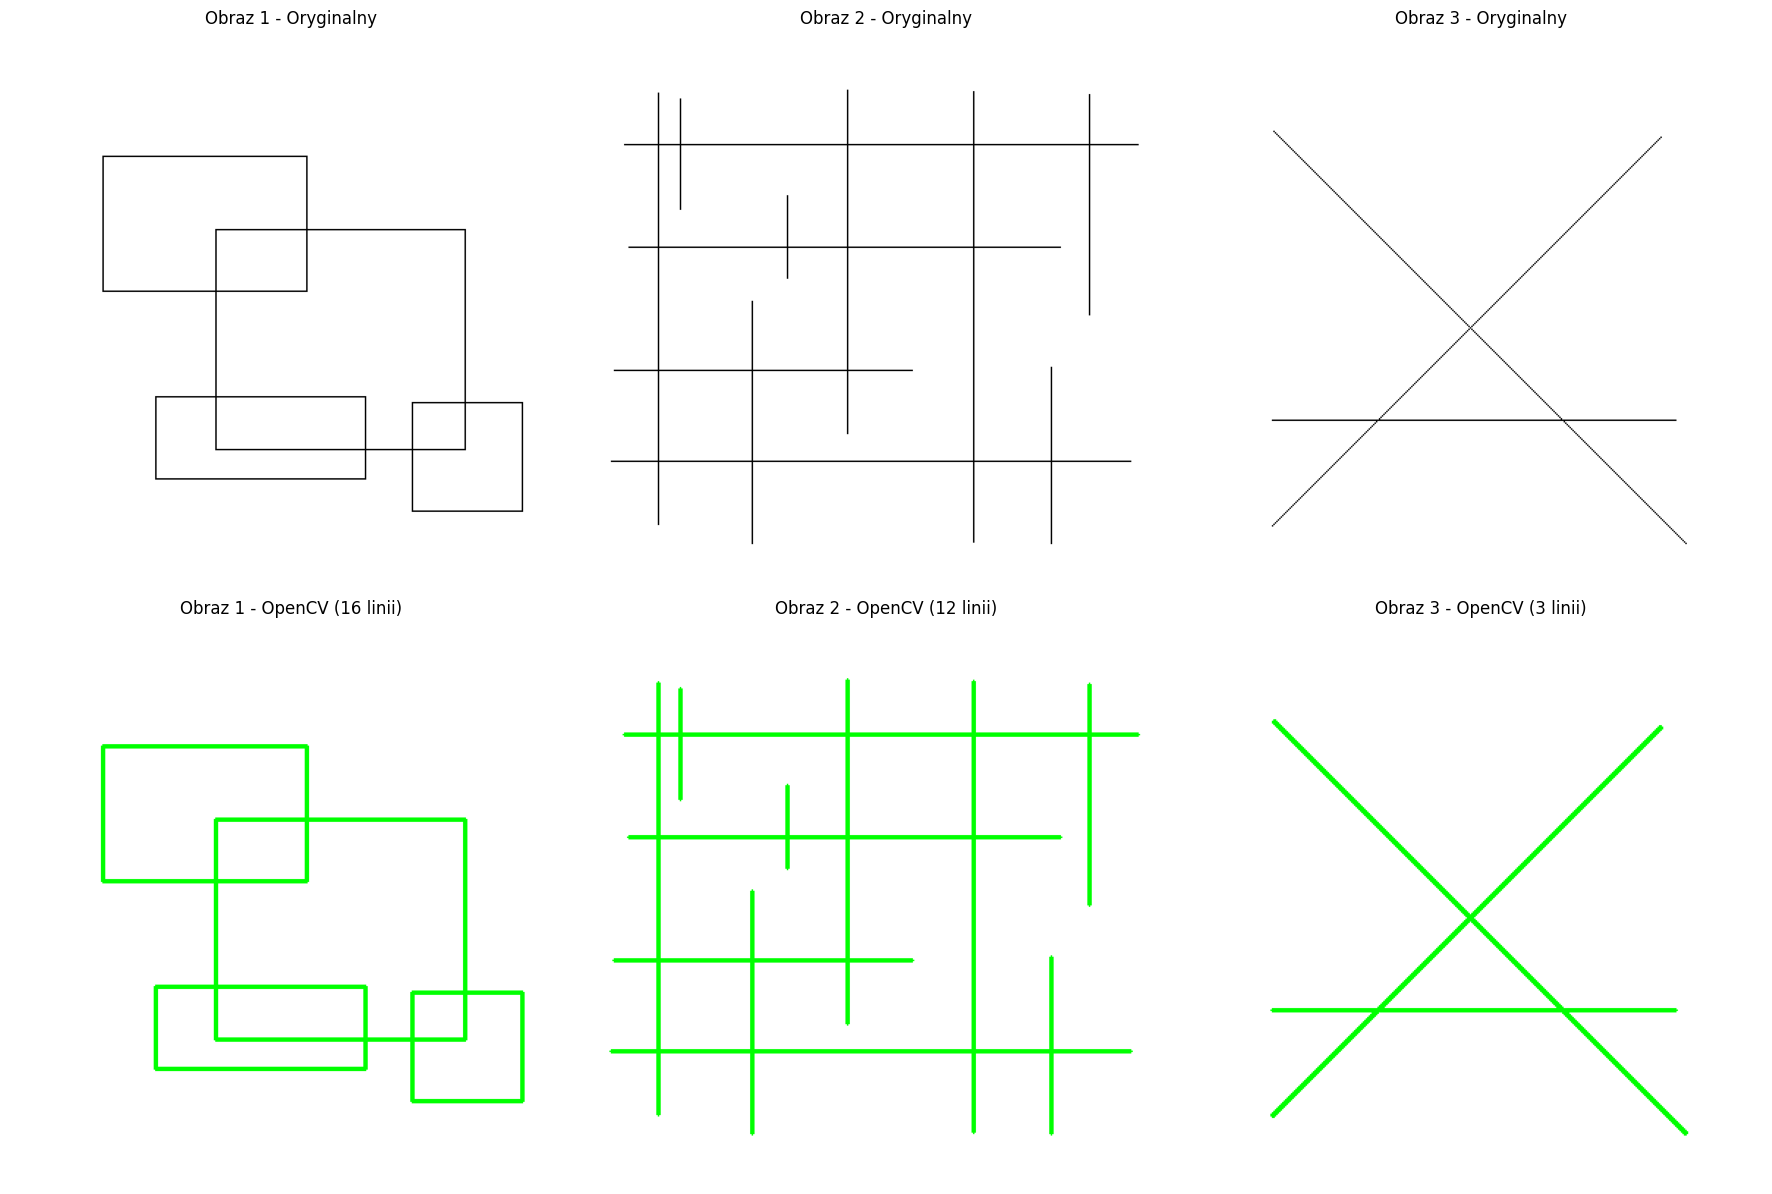

In [15]:
# Wizualizacja wyników OpenCV
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, result in enumerate(opencv_results):
    # Oryginalny obraz
    axes[0, i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title("Obraz " + str(i+1) + " - Oryginalny")
    axes[0, i].axis('off')
    
    # Obraz z liniami (OpenCV)
    axes[1, i].imshow(cv2.cvtColor(result['line_img'], cv2.COLOR_BGR2RGB))
    axes[1, i].set_title("Obraz " + str(i+1) + " - OpenCV (" + str(result["num_lines"]) + " linii)")
    axes[1, i].axis('off')

plt.tight_layout()

## Porównanie wyników

Porównanie wyników implementacji własnej z implementacją OpenCV.


In [16]:
# Porównanie wyników
print("=== Porównanie wyników ===")
print("Implementacja własna vs OpenCV:")
print()

for i in range(len(images)):
    own_lines = all_results[i]['num_lines']
    opencv_lines = opencv_results[i]['num_lines']
    
    print("Obraz " + str(i+1) + ":")
    print("  Implementacja własna:", own_lines, "linii")
    print("  OpenCV:", opencv_lines, "linii")
    print("  Różnica:", abs(own_lines - opencv_lines), "linii")

=== Porównanie wyników ===
Implementacja własna vs OpenCV:

Obraz 1:
  Implementacja własna: 14 linii
  OpenCV: 16 linii
  Różnica: 2 linii
Obraz 2:
  Implementacja własna: 45 linii
  OpenCV: 12 linii
  Różnica: 33 linii
Obraz 3:
  Implementacja własna: 11 linii
  OpenCV: 3 linii
  Różnica: 8 linii
